In [77]:
# Step 1: Import necessary libraries
import numpy as np
import pandas as pd
from econml.dr import DRLearner
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

In [78]:
# Step 2: Load the dataset
path = 'data/raw/multi_attribution_sample.csv'
data = pd.read_csv(path)
data.head()

,Global Flag,Major Flag,SMC Flag,Commercial Flag,IT Spend,Employee Count,PC Count,Size,Tech Support,Discount,Revenue
0,1,0,1,0,45537,26,26,152205,0,1,17688.36300
1,0,0,1,1,20842,107,70,159038,0,1,14981.43559
2,0,0,0,1,82171,10,7,264935,1,1,32917.13894
3,0,0,0,0,30288,40,39,77522,1,1,14773.76855
4,0,0,1,0,25930,37,43,91446,1,1,17098.69823


In [79]:
# Step 3: Preprocess the data
# Fill or drop missing values if any
data = data.dropna()

# Define features for W (controls), T (treatments), and Y (outcome)
W = data[['Global Flag', 'Major Flag', 'SMC Flag', 'Commercial Flag', 'IT Spend', 'Employee Count', 'PC Count', 'Size']]
T = data[['Tech Support', 'Discount']]
Y = data['Revenue']

# Step 4: Split the data into training and testing sets
X_train, X_test, T_train, T_test, Y_train, Y_test = train_test_split(W, T, Y, test_size=0.2, random_state=42)

# Step 5: Initialize models for the DR Learner
# For the outcome and treatment models, we'll use Random Forests
model_y = RandomForestRegressor(n_estimators=100, random_state=41)
model_t = RandomForestClassifier(n_estimators=100, random_state=42)

In [80]:
T_column, T_name = 'Tech Support', 'Tech Support'
# Initialize the DR Learner with model_final specified
dr_learner = DRLearner(
    model_regression=model_y,
    model_propensity=model_t,
    model_final=RandomForestRegressor(n_estimators=100, random_state=43),
    random_state=44
)

# Fit the model
dr_learner.fit(Y_train, T_train[T_column], X=X_train)

# Estimate the Conditional Average Treatment Effect (CATE)
cate = dr_learner.effect(X_test)


Average Treatment Effect (ATE) for Tech Support: 6710.64


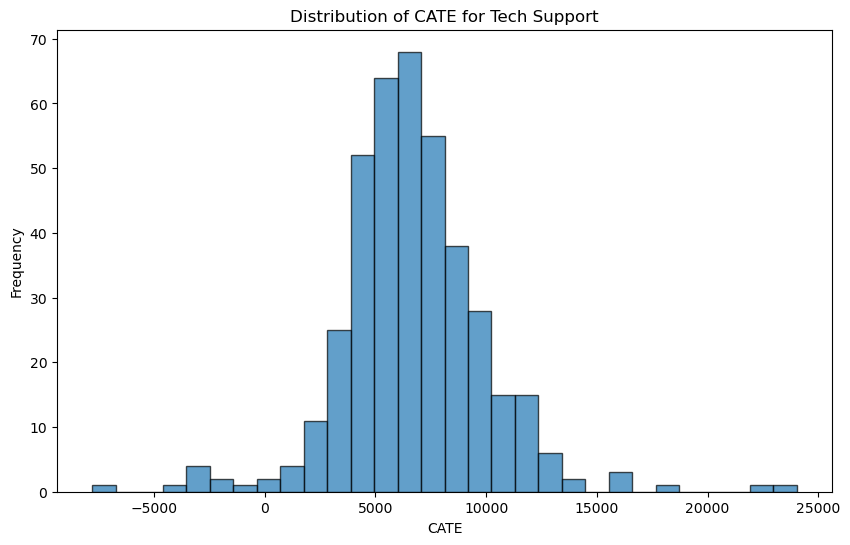

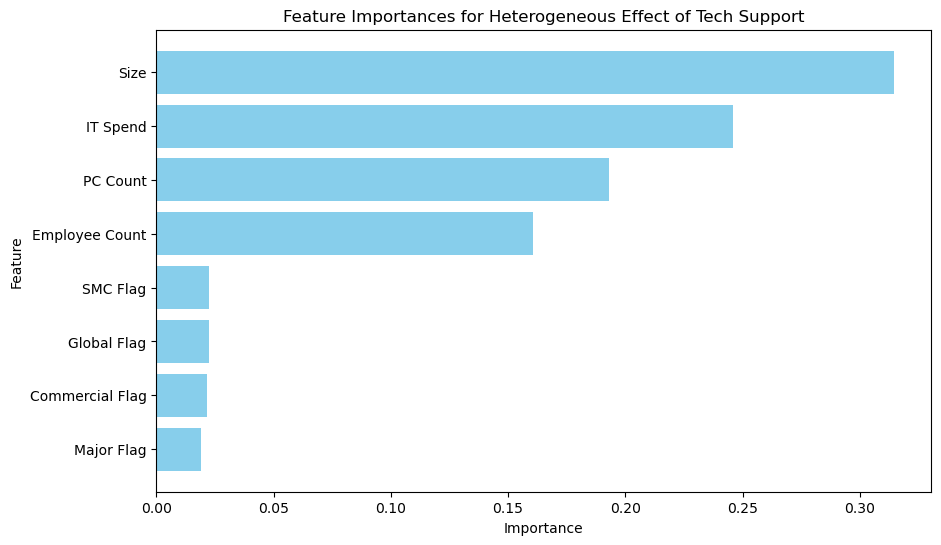


Average Treatment Effect (ATE) for Discount: 5458.63


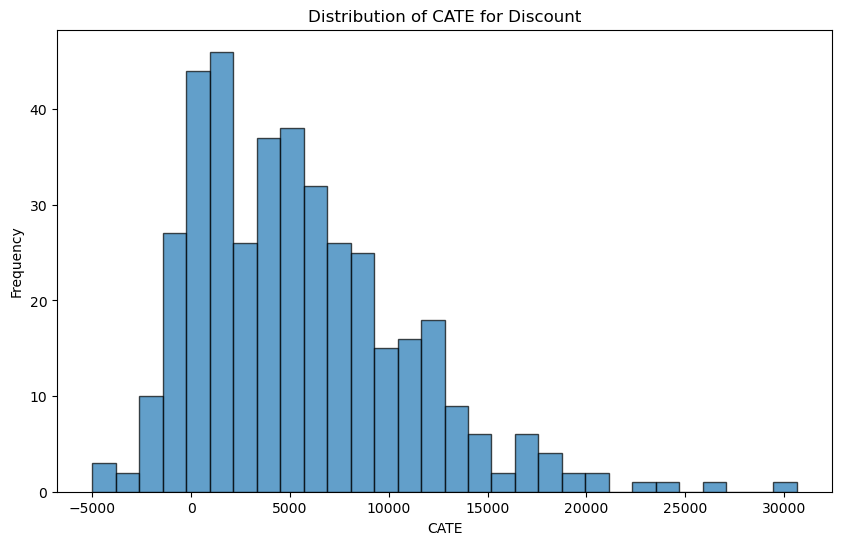

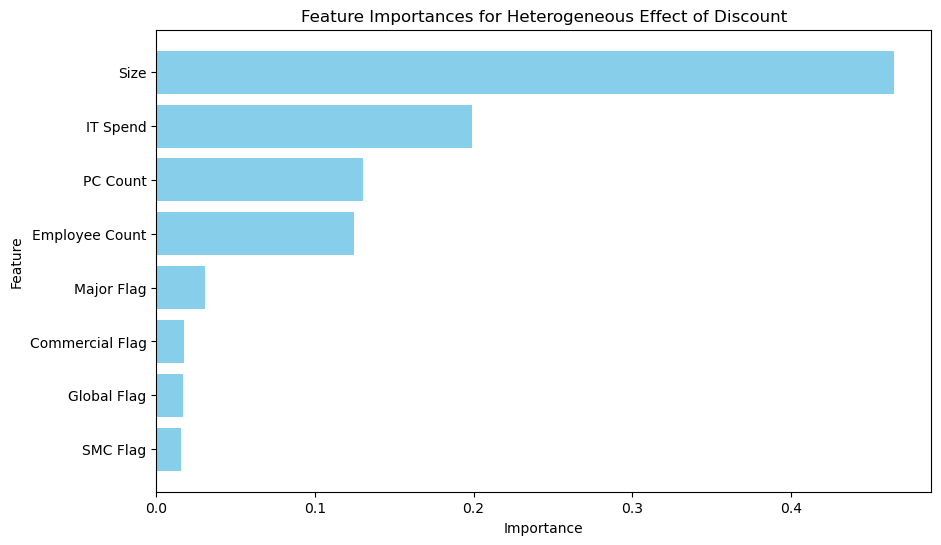

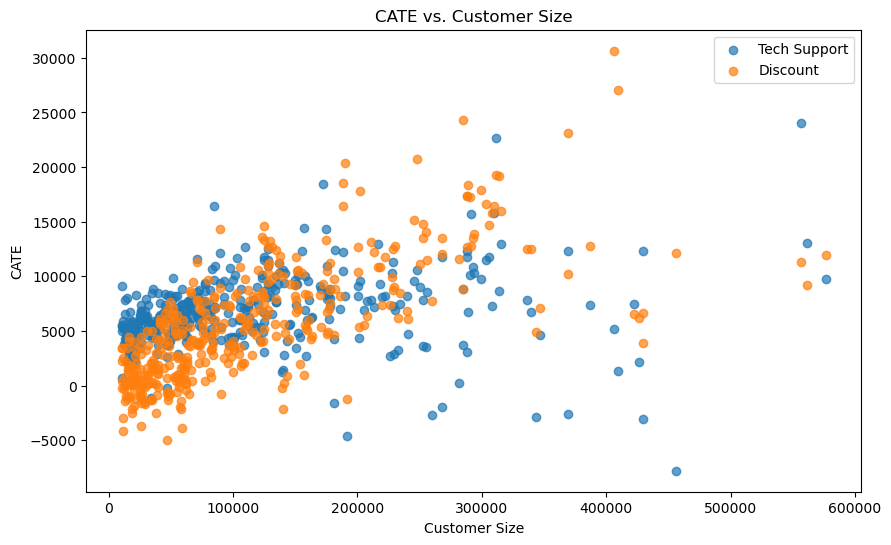

In [81]:


# Step 6: Function to fit DRLearner and analyze treatment effects
def analyze_treatment(T_column, T_name):
    # Initialize the DR Learner with model_final specified
    dr_learner = DRLearner(
        model_regression=model_y,
        model_propensity=model_t,
        model_final=RandomForestRegressor(n_estimators=100, random_state=42),
        random_state=42
    )
    
    # Fit the model
    dr_learner.fit(Y_train, T_train[T_column], X=X_train)
    
    # Estimate the Conditional Average Treatment Effect (CATE)
    cate = dr_learner.effect(X_test)
    
    # Access feature importances from the final model
    # Since model_final is a RandomForestRegressor, we can get feature_importances_
    # feature_importances = dr_learner.model_final_.feature_importances_
    feature_importances = dr_learner.fitted_models_final[0].feature_importances_
    feature_names = X_train.columns
    
    # Create a DataFrame for CATE
    cate_df = pd.DataFrame({
        'CATE': cate,
        'Revenue': Y_test.reset_index(drop=True)
    })
    
    # Print average treatment effect
    ate = np.mean(cate)
    print(f"\nAverage Treatment Effect (ATE) for {T_name}: {ate:.2f}")
    
    # Plot CATE distribution
    plt.figure(figsize=(10,6))
    plt.hist(cate, bins=30, edgecolor='k', alpha=0.7)
    plt.title(f'Distribution of CATE for {T_name}')
    plt.xlabel('CATE')
    plt.ylabel('Frequency')
    plt.show()
    
    # Plot feature importances
    importances_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importances
    }).sort_values(by='Importance', ascending=False)
    
    plt.figure(figsize=(10,6))
    plt.barh(importances_df['Feature'], importances_df['Importance'], color='skyblue')
    plt.gca().invert_yaxis()
    plt.title(f'Feature Importances for Heterogeneous Effect of {T_name}')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.show()
    
    return cate_df

# Analyze the effect of Tech Support
cate_tech_support = analyze_treatment('Tech Support', 'Tech Support')

# Analyze the effect of Discount
cate_discount = analyze_treatment('Discount', 'Discount')

# Step 7: Interpret the results

# Combine CATE results with customer features
results_tech_support = pd.concat([X_test.reset_index(drop=True), cate_tech_support], axis=1)
results_discount = pd.concat([X_test.reset_index(drop=True), cate_discount], axis=1)

# Example: Analyze CATE by customer size
plt.figure(figsize=(10,6))
plt.scatter(results_tech_support['Size'], results_tech_support['CATE'], alpha=0.7, label='Tech Support')
plt.scatter(results_discount['Size'], results_discount['CATE'], alpha=0.7, label='Discount')
plt.title('CATE vs. Customer Size')
plt.xlabel('Customer Size')
plt.ylabel('CATE')
plt.legend()
plt.show()